In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [3]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [4]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

In [6]:
tracking_df['gpid'] = tracking_df.apply(lambda x: str(x.gameId) + '-' + str(x.playId), axis=1)

In [7]:
runners = tracking_df.loc[(tracking_df['position'].isin(['WR'])) & (~tracking_df['route'].isna())].copy()
del tracking_df

In [8]:
# Convert nan forced floats to ints and NA
runners['nflId'] = runners['nflId'].astype('Int64')
runners['jerseyNumber'] = runners['jerseyNumber'].astype('Int64')

In [9]:
gpids = runners['gpid'].unique().tolist()

In [11]:
routes_df = pd.DataFrame(columns=['gpid', 'nflId', 'route', 'pos'])
index = 0
end_events = ['pass_arrived', 'pass_outcome_caught', 'out_of_bounds',
                       'pass_outcome_incomplete', 'first_contact', 'tackle', 'man_in_motion', 'play_action', 'handoff',
                       'pass_tipped', 'pass_outcome_interception', 'pass_shovel', 'line_set', 'pass_outcome_touchdown',
                       'fumble', 'fumble_offense_recovered', 'fumble_defense_recovered', 'touchdown', 'shift',
                       'touchback', 'penalty_flag', 'penalty_accepted', 'field_goal_blocked']

# Generate vectors of positions
for gpid in gpids:
    df = runners.loc[runners['gpid'] == gpid]
    players = df['nflId'].unique().tolist()
    for player in players:
        player_df = df.loc[(df['nflId'] == player)]
        if player > 0:
            start_frame = df.loc[(df['nflId'] == player) & (df['event'] == 'ball_snap')]['frameId'].min()
            end_frame = df.loc[(df['nflId'] == player) & (df['event'].isin(end_events))]['frameId'].min()
            if end_frame > start_frame:
                positions = []
                for frame in range(start_frame + 1, end_frame + 1):
                    # positions.append(player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist())
                    new_pos = player_df.loc[(player_df['frameId'] == frame)]['pos'].values[0].tolist()
                    new_pos.append(player_df.loc[(player_df['frameId'] == frame)]['s'].values[0])
                    positions.append(new_pos)
                positions = np.array(positions)
                try:
                    routes_df.loc[index] = {
                        'gpid': str(gpid),
                        'nflId': int(player),
                        'route': str(player_df.loc[(player_df['frameId'] == 1)]['route'].values[0]),
                        'pos': positions - positions[0]
                    }
                    index += 1
                except IndexError:
                    print(f'Data error for gpid {gpid}, player {player} (Start {start_frame} | End {end_frame})')

del runners

In [12]:
# Convert position sequences to 2d array with np.histogram2d

In [13]:
# Convert 2d array to 1d array

In [14]:
x = [0, 0]
y = [0, 0]

for idx, row in routes_df.iterrows():
    if row['pos'][:, 0].min() < x[0]: x[0] = row['pos'][:, 0].min()
    if row['pos'][:, 0].max() > x[1]: x[1] = row['pos'][:, 0].max()
    if row['pos'][:, 1].min() < y[0]: y[0] = row['pos'][:, 1].min()
    if row['pos'][:, 1].max() > y[1]: y[1] = row['pos'][:, 1].max()
    #plt.scatter(row['pos'][:, 0], row['pos'][:, 1], c=row['pos'][:, 2])
x = [np.floor(x[0]), np.ceil(x[1])]
#plt.xlim(x[0] - 1, x[1] + 1)
y[0] = -1 * np.ceil(max(abs(y[0]), abs(y[1])))
y[1] = abs(y[0])
#plt.ylim(y[0] - 1, y[1] + 1)

In [15]:
x_dim = int(abs(x[0]) + abs(x[1]))
y_dim = int(abs(y[0]) + abs(y[1]))

In [16]:
grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)

In [17]:
grids = []
for idx, row in routes_df.iterrows():
    grid = np.zeros(x_dim * y_dim).reshape(x_dim, y_dim)
    for position in row['pos']:
        grid[int(position[0]), int(position[1])] = position[2]
    grids.append(grid.reshape(x_dim * y_dim))

In [23]:
routes_df['grid'] = grids
routes_df.drop(['pos'], axis=1, inplace=True)

In [19]:
# flatten the images
n_samples = len(grids)

# Create a classifier: a support vector classifier
clf = svm.SVC(gamma=0.005, kernel='rbf')

# Split data into 50% train and 50% test subsets
x_train, x_test, y_train, y_test = train_test_split(grids, routes_df['route'], test_size=0.6, shuffle=False, random_state=1)

# Learn the digits on the train subset
clf.fit(x_train, y_train)

# Predict the value of the digit on the test subset
predicted = clf.predict(x_test)

In [20]:
print(
    f'Classification report for classifier {clf}:\n'
    f'{metrics.classification_report(y_test, predicted)}\n'
)

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier SVC(gamma=0.005):
              precision    recall  f1-score   support

       ANGLE       0.00      0.00      0.00         4
      CORNER       0.30      0.01      0.02      1036
       CROSS       0.51      0.30      0.38      2453
        FLAT       0.51      0.51      0.51       923
          GO       0.42      0.73      0.54      5891
       HITCH       0.49      0.64      0.56      4394
          IN       0.43      0.24      0.31      2230
         OUT       0.51      0.25      0.34      2353
        POST       0.37      0.14      0.21      1986
      SCREEN       0.45      0.81      0.58       746
       SLANT       0.53      0.35      0.42      1755
       WHEEL       0.00      0.00      0.00         5
   undefined       0.00      0.00      0.00        11

    accuracy                           0.46     23787
   macro avg       0.35      0.31      0.30     23787
weighted avg       0.46      0.46      0.42     23787




/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[   0    0    1    0    0    1    0    0    0    2    0    0    0]
 [   0    9   20    0  692  114   48    6  134   11    2    0    0]
 [   0    0  740  153 1031  180    2   88    2  238   19    0    0]
 [   0    0  190  468   61   31    1   14    0  128   30    0    0]
 [   0    4   99   41 4288 1062   27    9  132  143   86    0    0]
 [   0    3   81   90 1007 2791  115   57   46   94  110    0    0]
 [   0    0   33    5  720  513  537  230   83   21   88    0    0]
 [   0    4  140   46  622  322  328  591   85   28  187    0    0]
 [   0   10   29    0 1250  254  122   15  286   17    3    0    0]
 [   0    0   32   21   72   14    2    0    0  603    2    0    0]
 [   0    0   83   91  357  366   55  141    2   53  607    0    0]
 [   0    0    1    0    2    0    0    0    0    2    0    0    0]
 [   0    0    0    1    5    3    1    0    0    0    1    0    0]]


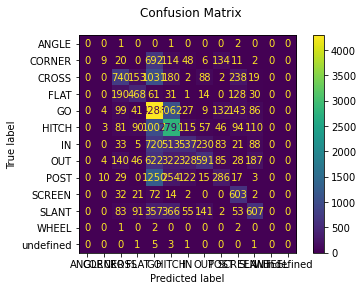

<Figure size 1440x720 with 0 Axes>

In [37]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

(array([1.1156e+04, 9.8780e+03, 2.9360e+03, 1.6390e+03, 3.7930e+03,
        7.2940e+03, 1.5890e+03, 1.2870e+03, 1.1000e+01, 6.2000e+01]),
 array([ 0. ,  1.2,  2.4,  3.6,  4.8,  6. ,  7.2,  8.4,  9.6, 10.8, 12. ]),
 <BarContainer object of 10 artists>)

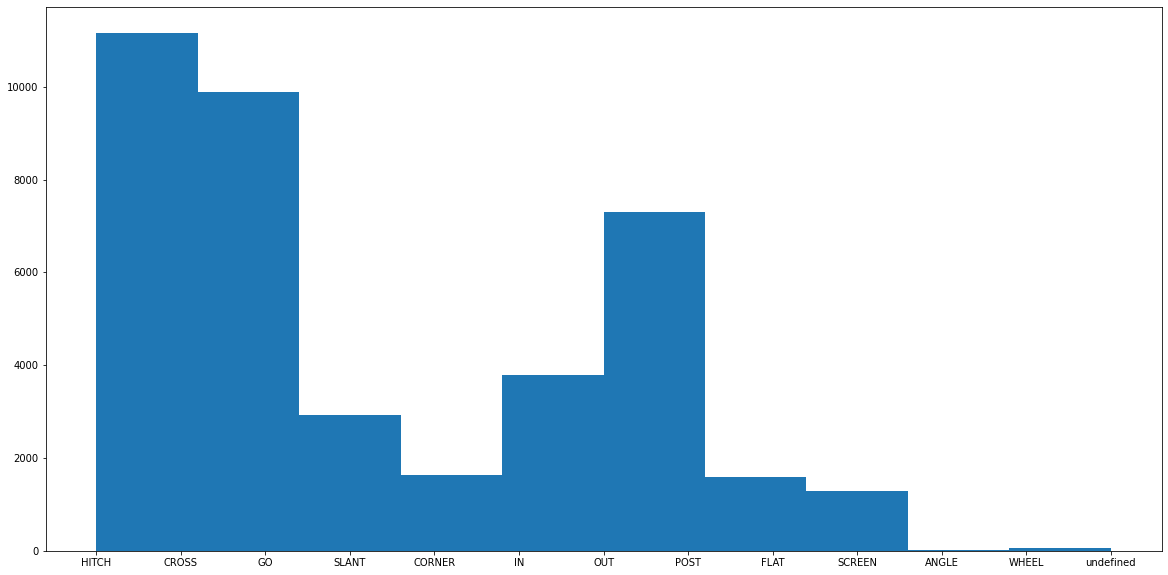

In [30]:
plt.figure(figsize=(20,10))
plt.hist(routes_df['route'])

In [32]:
routes_df['route'].count()

39645

In [58]:
routes_df.loc[routes_df['route'] == 'WHEEL']['route'].count()

10

In [35]:
7142/39645

0.1801488207844621

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

In [44]:
scaler = StandardScaler()

scaler.fit(x_train)
x_train2 = scaler.transform(x_train)
x_test2 = scaler.transform(x_test)

In [53]:
clf2 = MLPClassifier(solver='lbfgs', random_state=1, max_iter=1000)
clf2.fit(x_train2, y_train)

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:559: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs')

In [54]:
predicted2 = clf2.predict(x_test2)

In [55]:
print(
    f'Classification report for classifier {clf2}:\n'
    f'{metrics.classification_report(y_test, predicted2)}\n'
)

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification report for classifier MLPClassifier(max_iter=1000, random_state=1, solver='lbfgs'):
              precision    recall  f1-score   support

       ANGLE       0.00      0.00      0.00         4
      CORNER       0.19      0.15      0.17      1036
       CROSS       0.45      0.46      0.45      2453
        FLAT       0.41      0.41      0.41       923
          GO       0.54      0.61      0.57      5891
       HITCH       0.58      0.53      0.55      4394
          IN       0.30      0.27      0.28      2230
         OUT       0.35      0.32      0.33      2353
        POST       0.27      0.31      0.29      1986
      SCREEN       0.59      0.64      0.62       746
       SLANT       0.38      0.33      0.35      1755
       WHEEL       0.00      0.00      0.00         5
   undefined       0.00      0.00      0.00        11

    accuracy                           0.45     23787
   macro avg       0.31      0.31      0.31     23787
weighted avg       0.44      0.45  

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[   0    0    1    0    1    1    0    0    0    1    0    0    0]
 [   0  153   74    2  280   57   91   66  284   10   19    0    0]
 [   0   48 1131  200  383  126   73  183  108   96   95    2    8]
 [   0    0  211  374   49   78   11   45    6   75   73    0    1]
 [   0  171  304   37 3575  593  203  143  598   47  210    0   10]
 [   0   67  146   89  751 2334  359  226  200   41  174    0    7]
 [   0   84  117   15  281  282  604  457  239    6  138    0    7]
 [   0   84  213   57  227  216  409  756  155   19  206    0   11]
 [   0  182  100    1  678  113  163   87  618    8   31    0    5]
 [   0    4   71   61   68   31    5    6    6  481   12    1    0]
 [   0   11  153   69  346  197  112  212   33   30  583    0    9]
 [   0    0    2    1    1    0    0    0    0    1    0    0    0]
 [   0    1    1    0    2    1    2    2    2    0    0    0    0]]


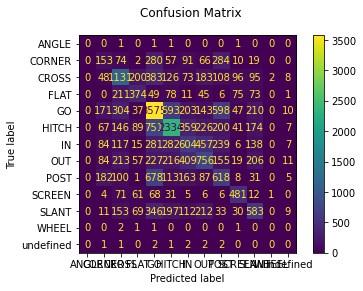

In [56]:
disp2 = metrics.ConfusionMatrixDisplay.from_predictions(y_test, predicted2)
disp2.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp2.confusion_matrix}')
plt.show()

In [59]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()

In [60]:
model.fit(x_train2, y_train)

RandomForestClassifier()

In [61]:
y_pred = model.predict(x_test2)

In [65]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

In [63]:
accuracy_score(y_pred, y_test)
print(classification_report(y_pred, y_test))

/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       ANGLE       0.00      0.00      0.00         0
      CORNER       0.06      0.27      0.10       224
       CROSS       0.51      0.56      0.53      2226
        FLAT       0.60      0.48      0.54      1144
          GO       0.71      0.50      0.59      8472
       HITCH       0.63      0.60      0.62      4644
          IN       0.30      0.43      0.35      1565
         OUT       0.29      0.46      0.36      1482
        POST       0.25      0.33      0.28      1488
      SCREEN       0.69      0.61      0.65       846
       SLANT       0.43      0.45      0.44      1694
       WHEEL       0.00      0.00      0.00         0
   undefined       0.00      0.00      0.00         2

    accuracy                           0.50     23787
   macro avg       0.34      0.36      0.34     23787
weighted avg       0.56      0.50      0.52     23787



/home/spencer/Projects/cosc301/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [64]:
confusion_matrix(y_pred, y_test)

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0],
       [   0,   60,   20,    0,   33,   13,   20,   28,   45,    1,    4,
           0,    0],
       [   0,   50, 1251,  158,  226,  101,   58,  165,   54,   53,  107,
           2,    1],
       [   1,    2,  167,  553,   79,  110,   18,   57,    2,   59,   94,
           1,    1],
       [   3,  505,  519,   36, 4208,  898,  482,  406, 1016,   56,  340,
           1,    2],
       [   0,   45,   78,   25,  643, 2782,  428,  279,  129,   30,  201,
           0,    4],
       [   0,   76,   34,    4,   89,  125,  670,  347,  150,    1,   68,
           0,    1],
       [   0,   21,  132,   18,   57,   87,  272,  688,   59,    3,  145,
           0,    0],
       [   0,  240,   60,    2,  291,  112,  153,  122,  490,    2,   15,
           0,    1],
       [   0,    4,   98,   85,   46,   42,    6,   15,    8,  516,   25,
           1,    0],
       [   0,   33,   94,   42,  219,  123,  123, 